In [1]:
!pip install open3d matplotlib
!pip install trimesh
!pip install pyrender
%env SKLEARN_ALLOW_DEPRECATED_SKLEARN_PACKAGE_INSTALL=True
%pip install mesh-to-sdf
!pip install scikit-image


env: SKLEARN_ALLOW_DEPRECATED_SKLEARN_PACKAGE_INSTALL=True
Note: you may need to restart the kernel to use updated packages.


In [20]:
pose_file="/home/koerner/Project/nice-slam/Datasets/gt_own/room0/traj.txt"
ply_file="/home/koerner/Project/nice-slam/Datasets/Replica/room0_mesh.ply"


#from mesh_to_sdf import mesh_to_voxels
import trimesh
import pyrender
import skimage
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import os
import math
import sys
import cv2
ply_file = '/home/koerner/Project/nice-slam/Datasets/Replica/room0_mesh.ply'  # Update with your path
ply_file = '/home/koerner/Project/nice-slam/Datasets/Replica/room0_mesh.ply'  # Update with your path
ourMesh = trimesh.load('/home/koerner/Project_Dogu/nice-slam/DataSetEval/final_mesh_eval_rec.obj')
gtMesh = trimesh.load('/home/koerner/Project/nice-slam/Datasets/Replica/room0_mesh.ply')

#/home/koerner/Project/nice-slam/output/Own/room0/mesh/00990_mesh_color.ply
#/home/koerner/Project/nice-slam/Datasets/Replica/room0_mesh.ply
#/home/koerner/Project_Dogu/nice-slam/DataSetEval/room0_mesh.obj
#/home/koerner/Project_Dogu/nice-slam/DataSetEval/final_mesh_eval_rec.obj
try:
    mesh = trimesh.load(ply_file)
except Exception as e:
    print(f"Error loading mesh: {e}")

os.environ['PYOPENGL_PLATFORM'] = 'egl'

# Added Psnr

In [21]:

def PSNR(color1, color2):
    mse = np.mean((color1 - color2) ** 2)
    psnrScore=20 * np.log10(255.0 / np.sqrt(mse))
    print("Psnr score",psnrScore)

# UPDATE Trajectories

In [22]:
rotation_matrix_y= np.array([[0, 0, 1, 0],
                            [0, 1, 0, 0],
                            [-1, 0, 0, 0],
                            [0, 0, 0, 1]])
rotation_matrix_x= np.array([[1, 0, 0, 0],
                            [0, 0, -1, 0],
                            [0, 1, 0, 0],
                            [0, 0, 0, 1]])
rotation_matrix_z= np.array([[0, -1, 0, 0],
                            [1, 0, 0, 0],
                            [0, 0, 1, 0],
                            [0, 0, 0, 1]])
T_wc = np.loadtxt(pose_file).reshape(-1, 4, 4)
T_wc = rotation_matrix_x@rotation_matrix_x@T_wc
trajectories = [T_wc[i] for i in range(T_wc.shape[0])]

In [ ]:
ourMesh.invert()
mesh = pyrender.Mesh.from_trimesh(ourMesh)
scene = pyrender.Scene(ambient_light= [0.8,0.8,0.8, 1.0])
scene.add(mesh)
camera = pyrender.PerspectiveCamera(yfov=np.pi / 3.0, aspectRatio=1.0)
s = np.sqrt(2)/2

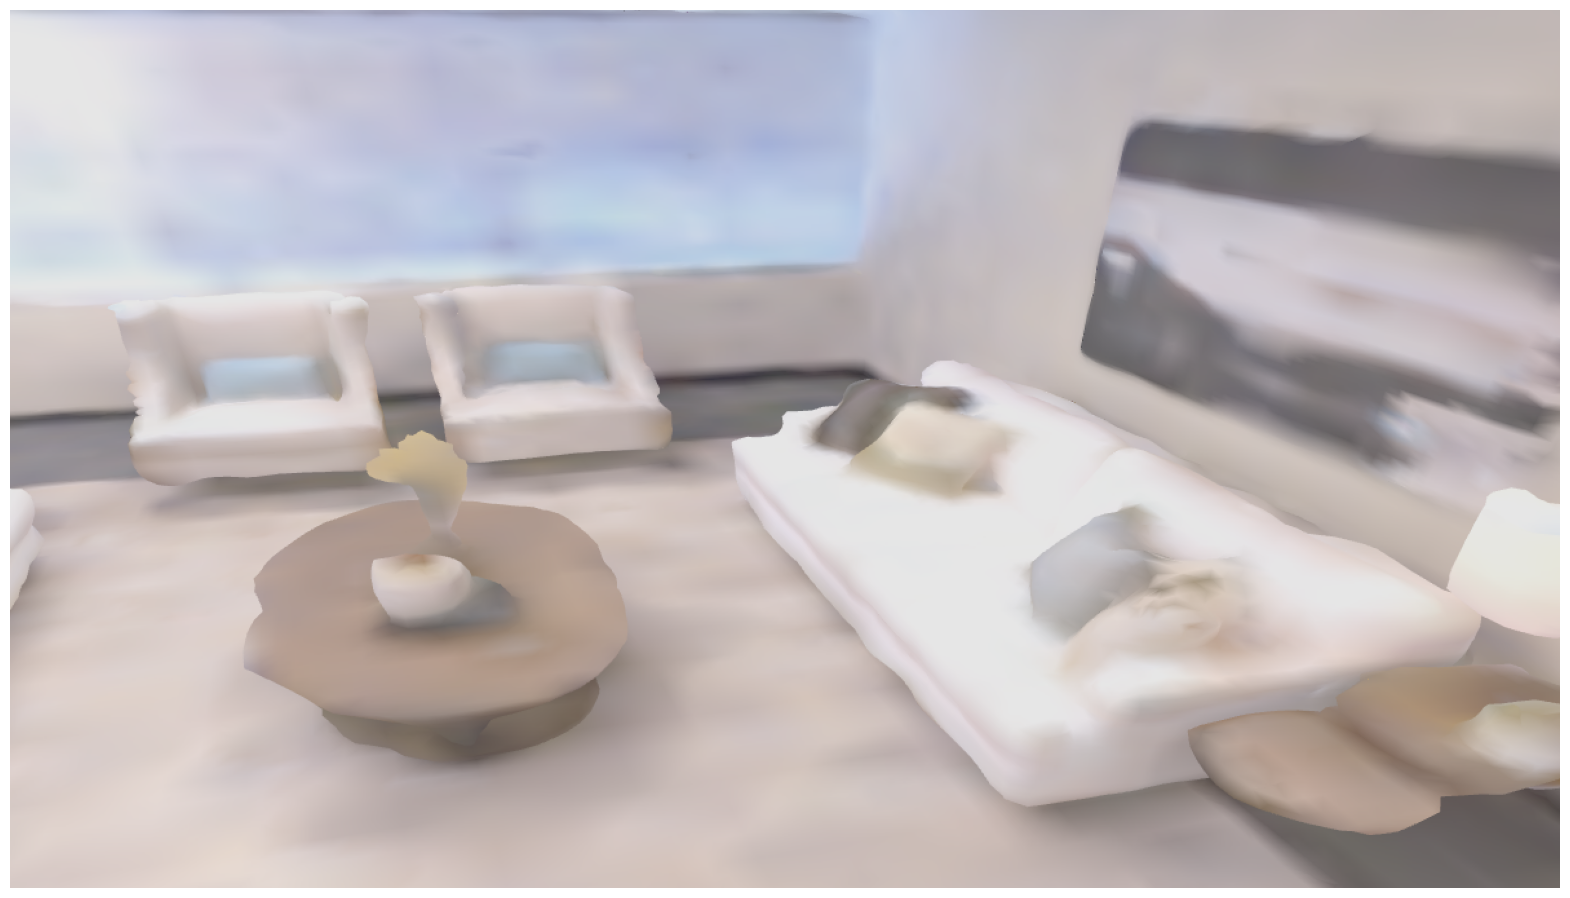

In [25]:

# Recalculate normals

camera_pose = trajectories[10]
camera_pose[[0,1,2], 3] = 1
scene.add(camera, pose=camera_pose)

try:
    r = pyrender.OffscreenRenderer(1200, 680, point_size=1.0)
    color, depth = r.render(scene)
    color1=color.copy()
    plt.figure(figsize=(20, 20))
    plt.axis('off')
    plt.imshow(color)
    plt.show()
finally:
    r.delete()  # Release resources
    scene = None

scene=None

In [12]:
color.shape

(680, 1200, 3)

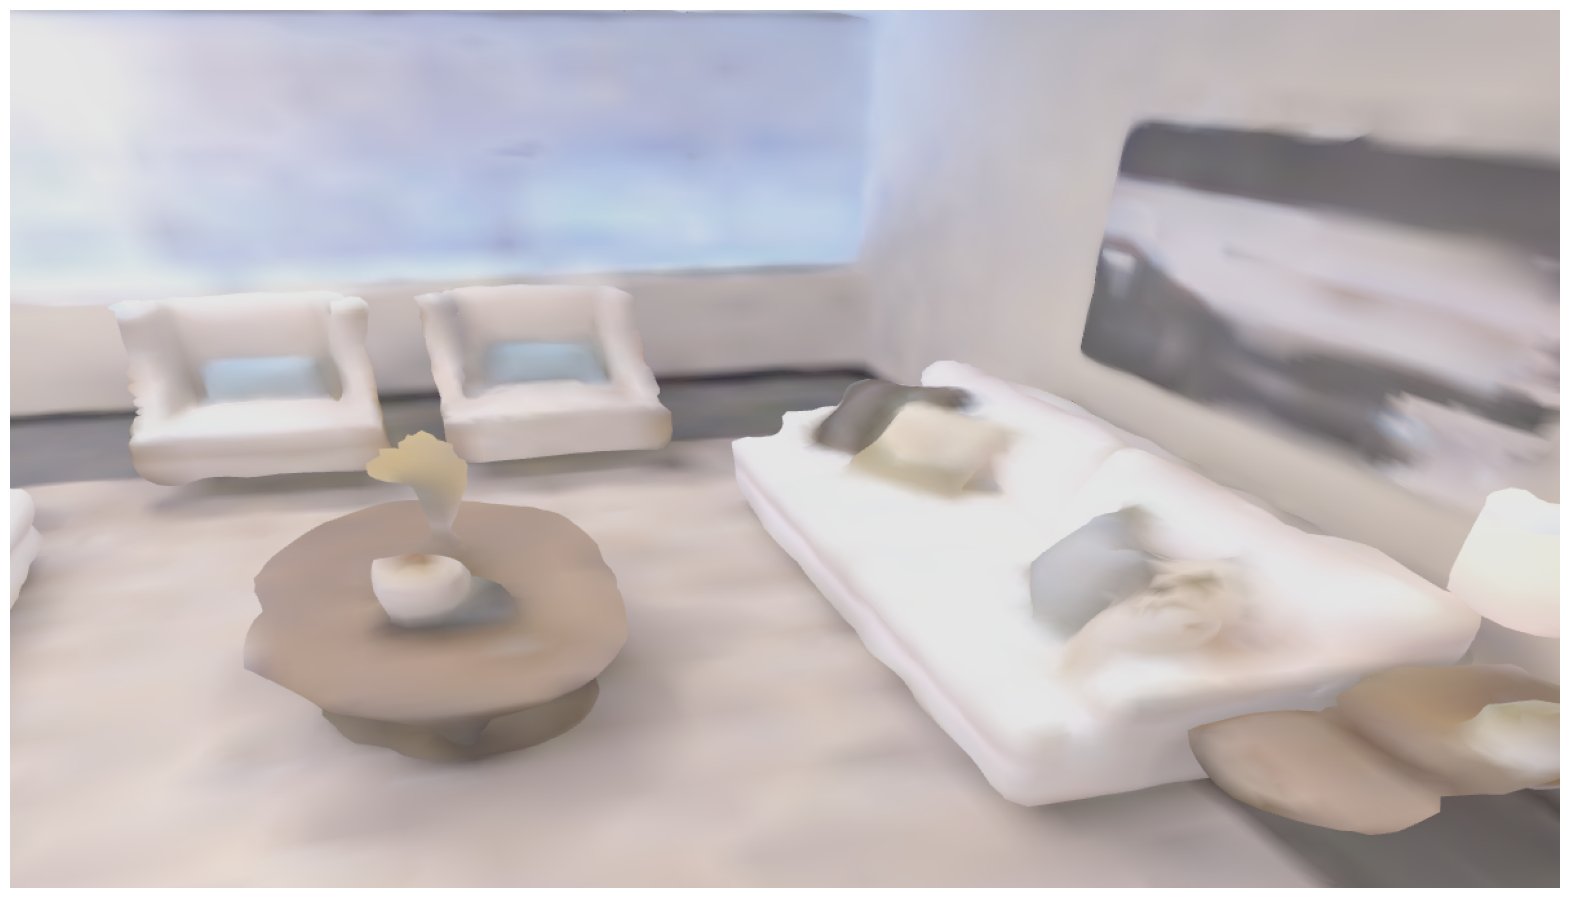

In [13]:
#/home/koerner/Project/nice-slam/output/Own/room0/mesh/00990_mesh_color.ply
#/home/koerner/Project/nice-slam/Datasets/Replica/room0_mesh.ply
#/home/koerner/Project_Dogu/nice-slam/DataSetEval/room0_mesh.obj
#/home/koerner/Project_Dogu/nice-slam/DataSetEval/final_mesh_eval_rec.obj
myMesh = trimesh.load('/home/koerner/Project_Dogu/nice-slam/DataSetEval/final_mesh_eval_rec.obj')


'''
voxels = mesh_to_voxels(myMesh, 64, pad=True)

vertices, faces, normals, _ = skimage.measure.marching_cubes(voxels, level=0)
mesh = trimesh.Trimesh(vertices=vertices, faces=faces, vertex_normals=normals)

mesh.show()'''
# Recalculate normals
mesh = pyrender.Mesh.from_trimesh(gtMesh)
gtScene = pyrender.Scene(ambient_light= [0.8,0.8,0.8, 1.0])
scene.add(mesh)
camera = pyrender.PerspectiveCamera(yfov=np.pi / 3.0, aspectRatio=1.0)
s = np.sqrt(2)/2
camera_pose = trajectories[10]
camera_pose[[0,1,2], 3] = 1
scene.add(camera, pose=camera_pose)


r = pyrender.OffscreenRenderer(1200, 680, point_size=1.0)
color, depth = r.render(scene)
color2=color.copy()
plt.figure(figsize=(20, 20))
plt.axis('off')
plt.imshow(color)
plt.show()
scene=None

Psnr score 28.35080953382734




# Load the mesh using trimesh
ply_file = ply_file  # Replace with your .ply file path
mesh = trimesh.load(ply_file)
vertices = np.asarray(mesh.vertices)
faces = np.asarray(mesh.faces)

# Load your 4x4 matrices representing the trajectory
pose_file =pose_file  # Replace with your pose file path

# Set up the plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the mesh (simple wireframe)
ax.plot_trisurf(vertices[:, 0], vertices[:, 1], vertices[:, 2], triangles=faces, linewidth=0.2, antialiased=True)

for idx, mat in enumerate(trajectories):
    # Extract camera position from the matrix
    camera_position = mat[:3, 3]
    ax.axis('off')
    # Set the camera position
    ax.view_init(azim=camera_position[0], elev=camera_position[1])

    # Save the image
    plt.savefig(f'image_{idx}.png')

plt.close()
